<a href="https://colab.research.google.com/github/Undertaker-86/deep_learning/blob/main/03_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1
- image recognition
- health care
- security

# 2
overfitting is when the model did too well on the training dataset, but generalize poorly

# 3
- Regularization
- Less Complex Model
- Weak learner and then ensemble learning
- Cross validation when choosing model

# 4
Read it

In [1]:
import torch
import torchvision
import torchvision.datasets
import matplotlib.pyplot as plt

!pip install torchmetrics
import torchmetrics

In [2]:
from pathlib import Path
from torchvision import transforms
data_path = Path("data")
data_path.mkdir(parents=True, exist_ok=True)

train_dataset = torchvision.datasets.MNIST(root=data_path,
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root=data_path,
                                           train=False,
                                           transform=transforms.ToTensor(),
                                           download=True)

In [3]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

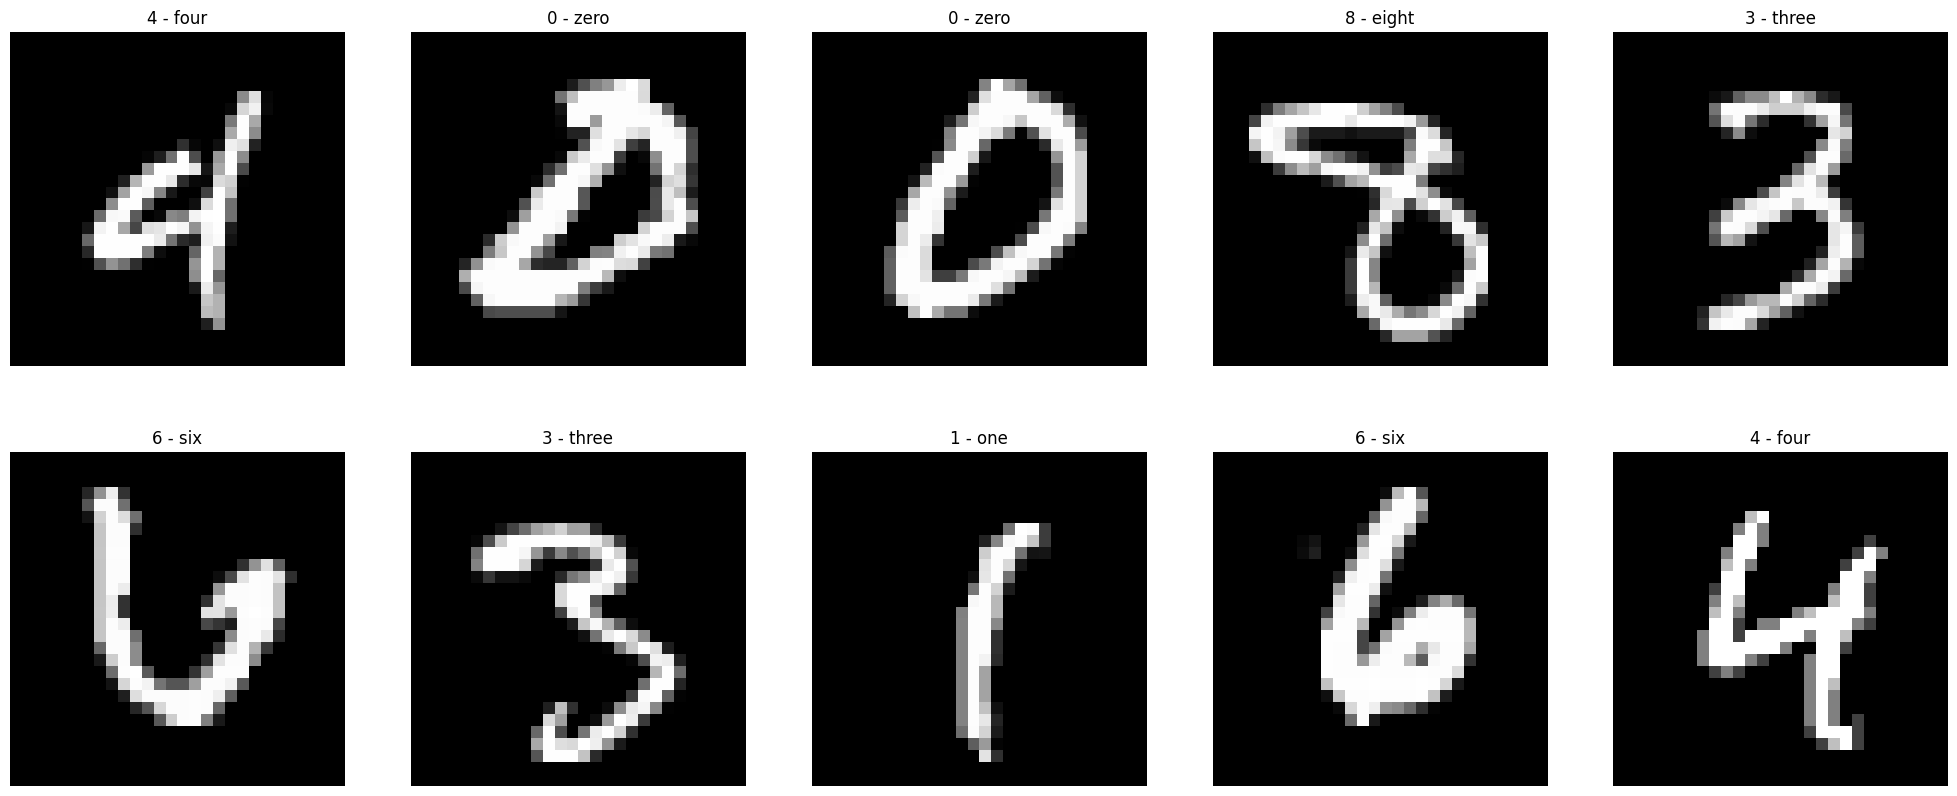

In [4]:
import numpy as np
train_len = len(train_dataset)
np.random.seed(42)
random_idx = np.random.randint(0,train_len, size=(10))
target_class = train_dataset.classes
num_cols = 5
num_rows = (len(random_idx)-1)//num_cols + 1
plt.figure(figsize=(num_cols*5, num_rows*5))
for i, index in enumerate(random_idx):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(train_dataset.data[index], cmap="gray")
    label = target_class[train_dataset.targets[index]]
    plt.title(label)
    plt.axis("off")

plt.show()

In [5]:
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=32,
                                               shuffle=True,
                                               )
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset,
                                               batch_size=32,
                                               shuffle=False,
                                               )

In [6]:
from torch import nn
class MyTinyVGG(nn.Module):
    def __init__(self, input_size:int, output_size: int, hidden_size: int,
                 image_height: int, image_width: int):
        super().__init__()
        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(in_channels=input_size,
                      out_channels=hidden_size,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU()
        )

        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_size,
                      out_channels=hidden_size,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                        )
        )

        self.conv_layer3 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_size,
                      out_channels=hidden_size,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU()
        )

        self.conv_layer4 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_size,
                      out_channels=hidden_size,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                        )
        )

        dummy_input = torch.randn(1, input_size, image_height, image_width)
        dummy_output = self.forward_features(dummy_input)
        classifier_input_features = dummy_output.numel()

        self.classification_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=classifier_input_features,
                      out_features=output_size)
        )
    def forward_features(self, x):
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = self.conv_layer3(x)
        x = self.conv_layer4(x)
        return x


    def forward(self, x:torch.Tensor):
        features = self.forward_features(x)
        output = self.classification_layer(features)
        return output

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

image, label = train_dataset[0]
image_shape = image.shape

print(f"Sample image shape: {image_shape}")

input_channels = image_shape[0]
image_height = image_shape[1]
image_width = image_shape[2]

print(f"  -> Input Channels (C): {input_channels}")
print(f"  -> Image Height (H): {image_height}")
print(f"  -> Image Width (W): {image_width}")

len_class = len(train_dataset.classes)
print(f"  -> Output Feature : {len_class}")

hidden_units = 10
torch.manual_seed(42)
torch.cuda.manual_seed(42)
CNN_clf = MyTinyVGG(input_size=input_channels,
                    output_size=len_class,
                    hidden_size=hidden_units,
                    image_height=image_height,
                    image_width=image_width).to(device)
CNN_clf

Using device: cuda
Sample image shape: torch.Size([1, 28, 28])
  -> Input Channels (C): 1
  -> Image Height (H): 28
  -> Image Width (W): 28
  -> Output Feature : 10


MyTinyVGG(
  (conv_layer1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
  (conv_layer2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer3): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
  (conv_layer4): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classification_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=160, out_features=10, bias=True)
  )
)

In [8]:
from tqdm.auto import tqdm
from typing import Dict, List
from torchmetrics import Accuracy

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn: Accuracy, # <-- Pass the metric function
               device: torch.device):
    """Perform a single training step"""
    accuracy_fn.reset()
    model.train()
    train_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()
        optimizer.step()

        accuracy_fn.update(y_pred, y)

    train_loss /= len(dataloader)
    train_acc = accuracy_fn.compute()
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn: Accuracy,
              device: torch.device):
    model.eval()
    test_loss = 0
    accuracy_fn.reset()

    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            accuracy_fn.update(test_pred_logits, y)
    test_loss /= len(dataloader)
    test_acc = accuracy_fn.compute()
    return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List[float]]:
    accuracy_fn = Accuracy(task="multiclass", num_classes=len_class).to(device)
    results = {"train_loss" : [], "train_acc" : [], "test_loss" : [], "test_acc" : []}
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           accuracy_fn=accuracy_fn,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        accuracy_fn=accuracy_fn,
                                        loss_fn=loss_fn,
                                        device=device)
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f} | "
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

In [9]:
epochs = 5
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=CNN_clf.parameters(), lr=0.001)
print("Start training")
model_results = train(model=CNN_clf,
                      train_dataloader=train_dataloader,
                      test_dataloader=test_dataloader,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=epochs,
                      device=device)
print("Training finished")

Start training


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2540 | train_acc: 0.9191 | test_loss: 0.0865 | test_acc: 0.9711 | 
Epoch: 2 | train_loss: 0.0859 | train_acc: 0.9732 | test_loss: 0.0756 | test_acc: 0.9748 | 
Epoch: 3 | train_loss: 0.0642 | train_acc: 0.9804 | test_loss: 0.0495 | test_acc: 0.9833 | 
Epoch: 4 | train_loss: 0.0544 | train_acc: 0.9832 | test_loss: 0.0508 | test_acc: 0.9837 | 
Epoch: 5 | train_loss: 0.0481 | train_acc: 0.9851 | test_loss: 0.0436 | test_acc: 0.9859 | 
Training finished


In [10]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
CNN_clf = MyTinyVGG(input_size=input_channels,
                    output_size=len_class,
                    hidden_size=hidden_units,
                    image_height=image_height,
                    image_width=image_width).to("cpu")
CNN_clf

epochs = 5
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=CNN_clf.parameters(), lr=0.001)
print("Start training")
model_results = train(model=CNN_clf,
                      train_dataloader=train_dataloader,
                      test_dataloader=test_dataloader,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=epochs,
                      device="cpu")
print("Training finished")

Start training


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2539 | train_acc: 0.9190 | test_loss: 0.0869 | test_acc: 0.9711 | 
Epoch: 2 | train_loss: 0.0862 | train_acc: 0.9733 | test_loss: 0.0732 | test_acc: 0.9755 | 
Epoch: 3 | train_loss: 0.0643 | train_acc: 0.9803 | test_loss: 0.0502 | test_acc: 0.9821 | 
Epoch: 4 | train_loss: 0.0546 | train_acc: 0.9831 | test_loss: 0.0550 | test_acc: 0.9829 | 
Epoch: 5 | train_loss: 0.0478 | train_acc: 0.9851 | test_loss: 0.0423 | test_acc: 0.9868 | 
Training finished


In [11]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
CNN_clf = MyTinyVGG(input_size=input_channels,
                    output_size=len_class,
                    hidden_size=hidden_units,
                    image_height=image_height,
                    image_width=image_width).to(device)
CNN_clf

epochs = 5
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=CNN_clf.parameters(), lr=0.001)
print("Start training")
model_results = train(model=CNN_clf,
                      train_dataloader=train_dataloader,
                      test_dataloader=test_dataloader,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=epochs,
                      device=device)
print("Training finished")

Start training


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2539 | train_acc: 0.9198 | test_loss: 0.0851 | test_acc: 0.9717 | 
Epoch: 2 | train_loss: 0.0861 | train_acc: 0.9736 | test_loss: 0.0745 | test_acc: 0.9747 | 
Epoch: 3 | train_loss: 0.0641 | train_acc: 0.9801 | test_loss: 0.0491 | test_acc: 0.9835 | 
Epoch: 4 | train_loss: 0.0542 | train_acc: 0.9832 | test_loss: 0.0502 | test_acc: 0.9833 | 
Epoch: 5 | train_loss: 0.0479 | train_acc: 0.9851 | test_loss: 0.0429 | test_acc: 0.9861 | 
Training finished


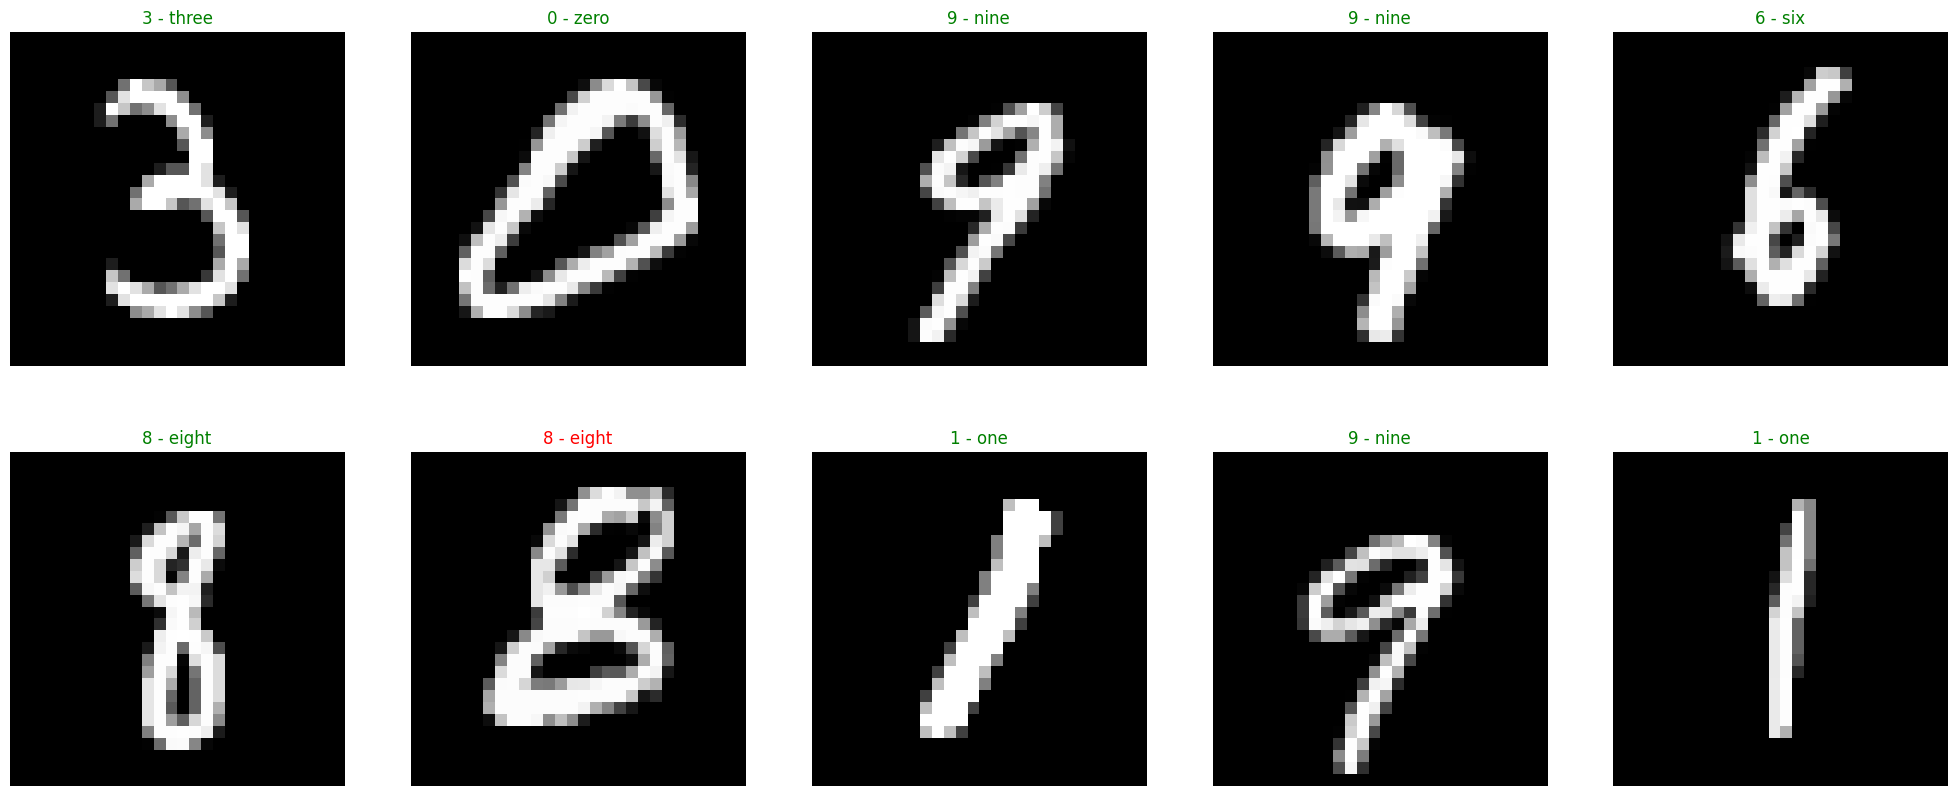

In [25]:
random_idx = torch.randint(low=0, high=len(test_dataset), size=(10,))
num_cols = 5
num_rows = (len(random_idx)-1)//num_cols + 1
plt.figure(figsize=(num_cols*5, num_rows*5))
for i, index in enumerate(random_idx, start=1):
    image, label = test_dataset[index]

    plt.subplot(num_rows, num_cols, i)
    plt.imshow(image.squeeze(), cmap="gray")
    label = target_class[label]
    with torch.inference_mode():
        image_for_model = image.unsqueeze(0).to(device)
        y_logit = CNN_clf(image_for_model)
        y_pred = torch.argmax(y_logit, dim=1)
        y_pred_class = target_class[y_pred.cpu()]
    if y_pred_class == label:
        plt.title(label, color="green")
    else:
        plt.title(label, color="red")
    plt.axis("off")

plt.show()

In [26]:
image, label = test_dataset[0]
image.shape

torch.Size([1, 28, 28])

In [27]:
def make_predictions(model: torch.nn.Module,
                     data_loader: torch.utils.data.DataLoader,
                     device:torch.device):
    y_preds = []
    y_trues = []
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader, desc="Predictions"):
            X, y = X.to(device), y.to(device)
            y_logits = model(X)
            y_pred = torch.argmax(y_logits, dim=1)
            y_preds.append(y_pred.cpu())
            y_trues.append(y.cpu())

    y_pred_tensor = torch.cat(y_preds)
    y_true_tensor = torch.cat(y_trues)

    return y_pred_tensor, y_true_tensor

In [29]:
y_preds, y_trues = make_predictions(model=CNN_clf,
                                    data_loader=test_dataloader,
                                    device=device)

from torchmetrics import ConfusionMatrix
class_names = test_dataset.classes
num_classes = len(class_names)

confmat = ConfusionMatrix(task="multiclass", num_classes=num_classes)

confmat_tensor = confmat(preds=y_preds,
                         target=y_trues)

Predictions:   0%|          | 0/313 [00:00<?, ?it/s]

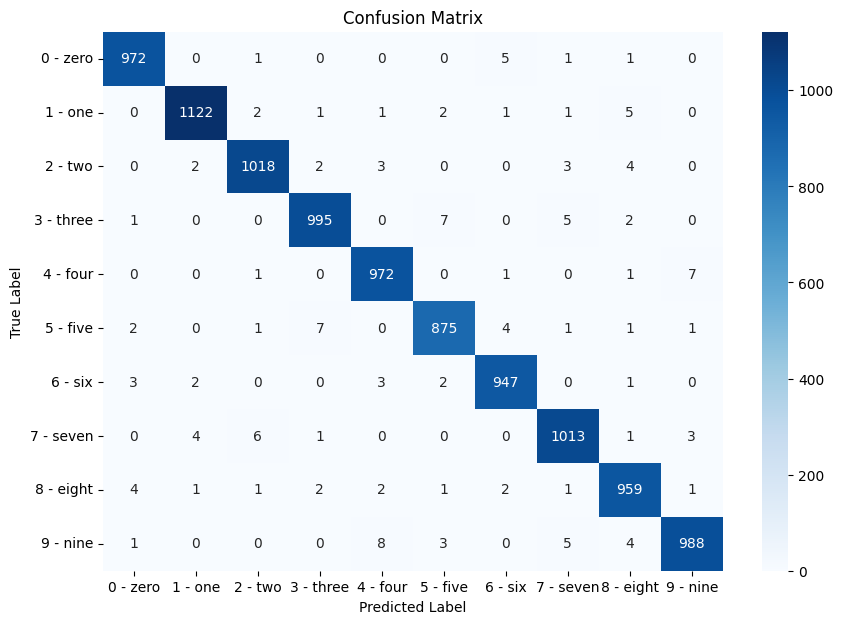

['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


In [32]:
import seaborn as sns
import pandas as pd

confmat_df = pd.DataFrame(
    confmat_tensor.numpy(),
    index=class_names,
    columns=class_names
)

plt.figure(figsize=(10, 7))

sns.heatmap(
    confmat_df,
    annot=True,
    fmt='g',
    cmap="Blues"
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
print(class_names)

Number of wrong predictions: 139


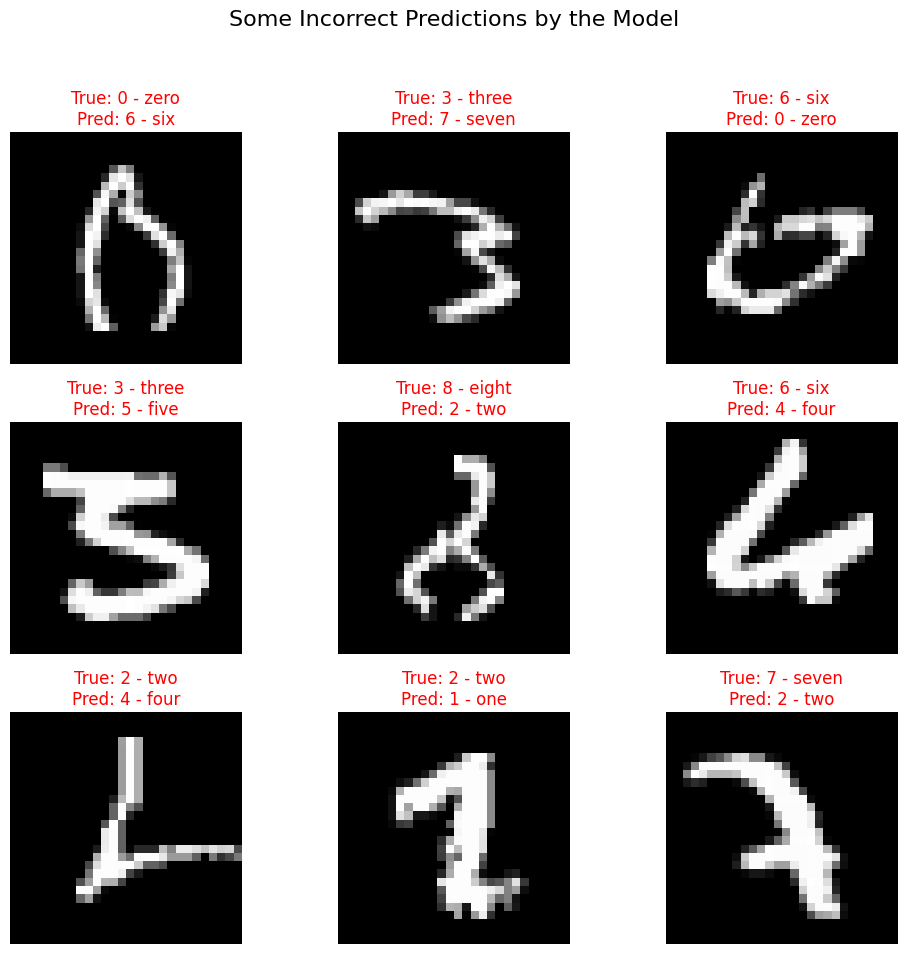

In [46]:
# Step 1: Find the indices where the model's predictions were wrong
wrong_pred_indices = torch.where(y_preds != y_trues)[0]
print(f"Number of wrong predictions: {len(wrong_pred_indices)}")

# Step 2: Select a random sample of wrong predictions to plot
# If you have many errors, you might want to shuffle them first.
# For simplicity, we'll just take the first 9.
num_to_plot = 9
indices_to_plot = wrong_pred_indices[:num_to_plot]

# Step 3: Setup the plot and loop through the selected indices
plt.figure(figsize=(10, 10))
plt.suptitle("Some Incorrect Predictions by the Model", fontsize=16)

for i, wrong_idx in enumerate(indices_to_plot):
    # Get the image, true label, and predicted label
    image, true_label_idx = test_dataset[wrong_idx]
    pred_label_idx = y_preds[wrong_idx]

    # Convert indices to class names
    true_label_name = class_names[true_label_idx]
    pred_label_name = class_names[pred_label_idx]

    # Plot the image
    plt.subplot(3, 3, i + 1)
    plt.imshow(image.squeeze(), cmap="gray")

    # Create a title showing the error
    title = f"True: {true_label_name}\nPred: {pred_label_name}"

    # Set the title color to red to indicate an error
    plt.title(title, color="red")
    plt.axis("off")

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
plt.show()

In [47]:
torch.where(y_preds != y_trues)[0]

tensor([ 324,  381,  445,  449,  582,  625,  646,  659,  684,  691,  720,  740,
         938,  947,  956,  965, 1014, 1039, 1112, 1226, 1247, 1260, 1290, 1299,
        1319, 1326, 1378, 1393, 1500, 1527, 1569, 1621, 1681, 1709, 1737, 1754,
        1878, 1901, 2018, 2035, 2043, 2070, 2109, 2129, 2130, 2135, 2182, 2266,
        2280, 2329, 2447, 2488, 2597, 2654, 2771, 2894, 2896, 2927, 2953, 2970,
        3060, 3073, 3100, 3330, 3422, 3520, 3558, 3626, 3767, 3796, 3806, 3808,
        3811, 3850, 3859, 3985, 4075, 4176, 4224, 4238, 4248, 4256, 4259, 4405,
        4477, 4497, 4571, 4740, 4761, 4807, 4823, 4860, 4876, 4879, 4890, 4956,
        5140, 5201, 5268, 5457, 5600, 5642, 5734, 5937, 5955, 5973, 5997, 6505,
        6559, 6560, 6571, 6572, 6576, 6597, 6625, 6651, 6783, 6796, 7216, 7511,
        7899, 7928, 8094, 8408, 9009, 9015, 9051, 9530, 9587, 9642, 9664, 9679,
        9692, 9729, 9749, 9770, 9792, 9811, 9904])

In [48]:
train_dataset = torchvision.datasets.FashionMNIST(root=data_path,
                                                  train=True,
                                                  transform=transforms.ToTensor(),
                                                  download=True)
test_dataset = torchvision.datasets.FashionMNIST(root=data_path,
                                                  train=False,
                                                  transform=transforms.ToTensor(),
                                                  download=True)

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 202kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.72MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 14.2MB/s]


In [57]:
image, label = train_dataset[0]
fashion_label = train_dataset.classes
len_fashion_label = len(fashion_label)
input_channel = image.shape[0]
image_width = image.shape[2]
image_height = image.shape[1]
hidden_units = 10
output_size = len_fashion_label
torch.manual_seed(42)
torch.cuda.manual_seed(42)
fashion_clf = MyTinyVGG(input_size=input_channel,
                        output_size=output_size,
                        hidden_size=hidden_units,
                        image_height=image_height,
                        image_width=image_width).to(device)
fashion_clf

MyTinyVGG(
  (conv_layer1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
  (conv_layer2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer3): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
  (conv_layer4): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classification_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=160, out_features=10, bias=True)
  )
)

In [59]:
loss_fn = nn.CrossEntropyLoss()
epochs = 5
optimizer = torch.optim.Adam(params=fashion_clf.parameters(),lr=0.001)
model_results = train(model=fashion_clf,
                      train_dataloader=train_dataloader,
                      test_dataloader=test_dataloader,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=epochs,
                      device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2526 | train_acc: 0.9197 | test_loss: 0.0831 | test_acc: 0.9727 | 
Epoch: 2 | train_loss: 0.0854 | train_acc: 0.9736 | test_loss: 0.0724 | test_acc: 0.9765 | 
Epoch: 3 | train_loss: 0.0638 | train_acc: 0.9805 | test_loss: 0.0516 | test_acc: 0.9825 | 
Epoch: 4 | train_loss: 0.0543 | train_acc: 0.9832 | test_loss: 0.0527 | test_acc: 0.9827 | 
Epoch: 5 | train_loss: 0.0477 | train_acc: 0.9856 | test_loss: 0.0415 | test_acc: 0.9863 | 


Predictions:   0%|          | 0/313 [00:00<?, ?it/s]

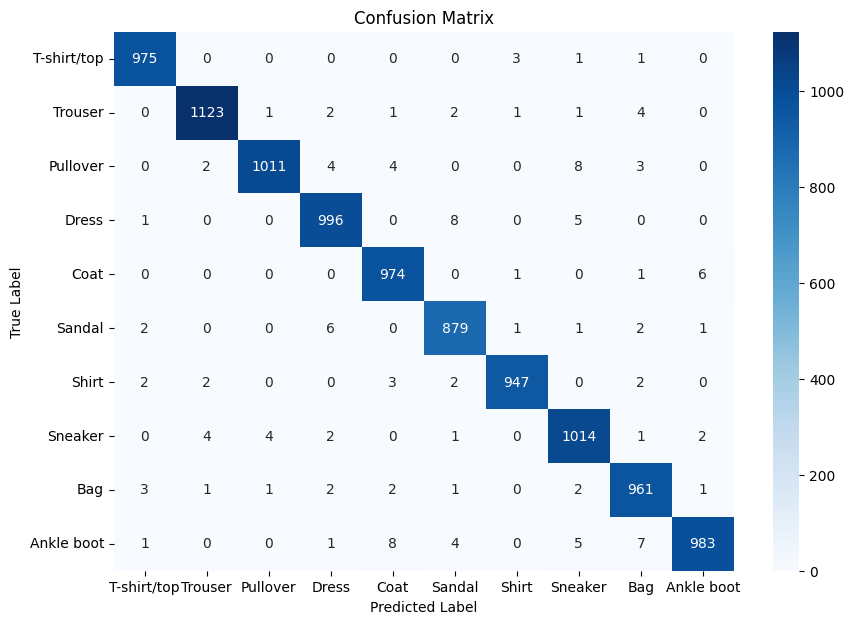

In [61]:
y_preds, y_trues = make_predictions(model=fashion_clf,
                                    data_loader=test_dataloader,
                                    device=device)
conf_tensor = ConfusionMatrix(task="multiclass", num_classes=len_fashion_label)
conf_data = conf_tensor(preds=y_preds,
                        target=y_trues)
class_names = test_dataset.classes
confmat_df = pd.DataFrame(
    conf_data.numpy(),
    index=class_names,
    columns=class_names
)
plt.figure(figsize=(10, 7))

sns.heatmap(
    confmat_df,
    annot=True,
    fmt='g',
    cmap="Blues"
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Number of wrong predictions: 137


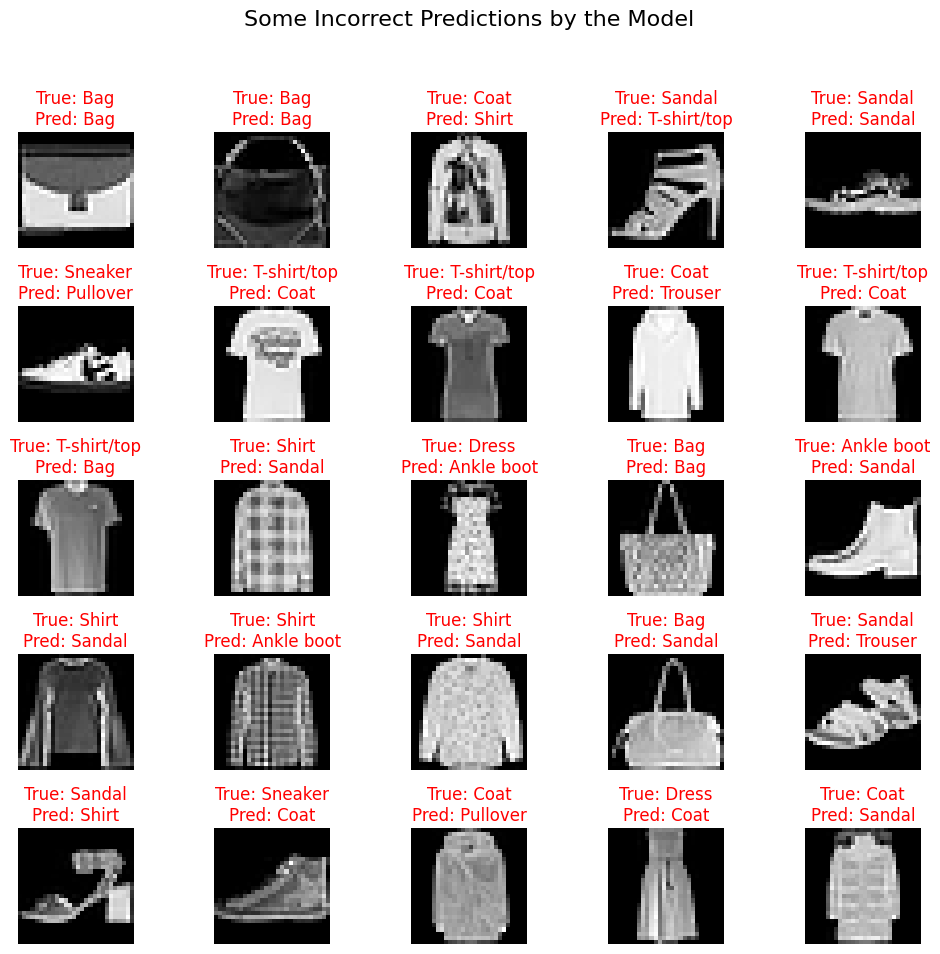

In [63]:
wrong_pred_indices = torch.where(y_preds != y_trues)[0]
print(f"Number of wrong predictions: {len(wrong_pred_indices)}")

num_to_plot = 25
indices_to_plot = wrong_pred_indices[:num_to_plot]

# Step 3: Setup the plot and loop through the selected indices
plt.figure(figsize=(10, 10))
plt.suptitle("Some Incorrect Predictions by the Model", fontsize=16)

for i, wrong_idx in enumerate(indices_to_plot):
    # Get the image, true label, and predicted label
    image, true_label_idx = test_dataset[wrong_idx]
    pred_label_idx = y_preds[wrong_idx]

    # Convert indices to class names
    true_label_name = class_names[true_label_idx]
    pred_label_name = class_names[pred_label_idx]

    # Plot the image
    plt.subplot(5, 5, i + 1)
    plt.imshow(image.squeeze(), cmap="gray")

    # Create a title showing the error
    title = f"True: {true_label_name}\nPred: {pred_label_name}"

    # Set the title color to red to indicate an error
    plt.title(title, color="red")
    plt.axis("off")

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
plt.show()